<a href="https://colab.research.google.com/github/Satwikram/NLP-Implementations/blob/main/BERT/Fine%20Tune%20BERT%20with%20Additional%20Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram Kodandaram

### Connecting to Kaggle

In [1]:
from google.colab import files
files.upload()


! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 76.0MB/s]


In [ ]:
!unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re

In [ ]:
!pip install transformers

In [39]:
df = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)

In [40]:
df.drop(columns="article_link", axis=1, inplace = True)

In [41]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


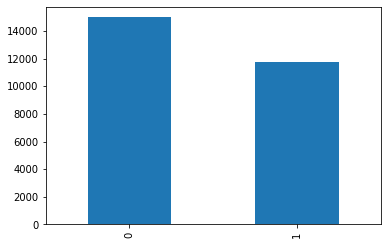

In [42]:
df["is_sarcastic"].value_counts().plot(kind="bar");

### Adding Customer Features

#### Removing Extra spaces before doing feature engineering

In [43]:
df["headline"] = df["headline"].apply(lambda x: re.sub("\s+", " ", x))

#### Number of Words in Sentence

In [44]:
df["length"] = df["headline"].apply(lambda x: len(x.split()))

In [45]:
df["length"]

0        12
1        14
2        14
3        13
4        11
         ..
26704     5
26705     4
26706     3
26707     8
26708     6
Name: length, Length: 26709, dtype: int64

#### Average Length

In [46]:
def average_length(text):

  word = text.split()
  len_char = [len(c) for c in word]
  average = sum(len_char) / len(word)
  return average

In [47]:
df["Average length of words"] = df["headline"].apply(average_length)

#### % of punctuations in text

In [48]:
def count_punct(text):

  count = sum([1 for char in text if char in string.punctuation])
  return round(count / (len(text) - text.count(" ")), 3) * 100

In [49]:
df["punct%"] = df["headline"].apply(count_punct)

#### % of Stopwords

In [50]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
def count_stopwords(text):

  count = sum([1 for word in text.split() if word in stopwords.words("english")])
  return round(count / len(text.split()), 3) * 100

In [52]:
df["stopwords%"] = df["headline"].apply(count_stopwords)

In [53]:
df.describe()

,is_sarcastic,length,Average length of words,punct%,stopwords%
count,26709.000000,26709.000000,26709.000000,26709.000000,26709.000000
mean,0.438953,9.845820,5.384915,2.163713,26.030308
std,0.496269,3.168955,0.984502,2.554881,13.842483
min,0.000000,2.000000,2.333333,0.000000,0.000000
25%,0.000000,8.000000,4.714286,0.000000,16.700000
50%,0.000000,10.000000,5.285714,1.700000,25.000000
75%,1.000000,12.000000,6.000000,3.500000,35.300000
max,1.000000,39.000000,13.333333,30.000000,87.500000


In [54]:
df.columns

Index(['headline', 'is_sarcastic', 'length', 'Average length of words',
       'punct%', 'stopwords%'],
      dtype='object')

In [55]:
df.head()

,headline,is_sarcastic,length,Average length of words,punct%,stopwords%
0,former versace store clerk sues over secret 'b...,0,12,5.583333,3.0,16.7
1,the 'roseanne' revival catches up to our thorn...,0,14,5.071429,4.2,42.9
2,mom starting to fear son's web series closest ...,1,14,4.714286,1.5,35.7
3,"boehner just wants wife to listen, not come up...",1,13,5.538462,2.8,38.5
4,j.k. rowling wishes snape happy birthday in th...,0,11,4.909091,3.7,27.3


### Preparing data for BERT

In [57]:
sequence_length = 128
num_samples = len(df)

num_samples, sequence_length

(26709, 512)

In [58]:
from transformers import BertTokenizer

In [59]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [60]:
tokens = tokenizer(df["headline"].tolist(), max_length = sequence_length, 
                   truncation = True, padding = "max_length", add_special_tokens = True,
                   return_tensors = "np")

### Taking Inputs Features

In [67]:
features = df.drop(columns = ["headline","is_sarcastic"]).values

In [68]:
features[0]

array([12.        ,  5.58333333,  3.        , 16.7       ])

In [66]:
Xids, Xmasks = tokens["input_ids"], tokens["attention_mask"]

### Taking Target

In [64]:
arr = df["is_sarcastic"].values

labels = np.zeros((num_samples, arr.max()+1))
labels.shape

labels[np.arange(num_samples), arr] = 1

### Creating Tensorflow Dataset

In [70]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmasks, features, labels))

In [71]:
dataset

<TensorSliceDataset shapes: ((512,), (512,), (4,), (2,)), types: (tf.int64, tf.int64, tf.float64, tf.float64)>

In [72]:
def map_fun(input_ids, masks, features, labels):

  return {"input_ids": input_ids,
          "attention_mask": masks,
          "features": features}, labels

In [73]:
dataset = dataset.map(map_fun)

### Dataset shuffling


In [75]:
batch_size = 16

In [76]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

In [77]:
train_split = 0.7
val_split = 0.15
ds_size = len(dataset)

train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)

train_ds = dataset.take(train_size)    
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)

### Building the BERT model

In [80]:
from transformers import TFAutoModel

In [102]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Fine-Tuning the BERT model

In [89]:
Xids.shape

(26709, 512)

In [103]:
input_ids = tf.keras.layers.Input(shape = (512,), name = "input_ids",
                                  dtype = "int32")

mask = tf.keras.layers.Input(shape = (512,), name = "attention_mask",
                                  dtype = "int32")

features = tf.keras.layers.Input(shape = (4,), name = "features",
                                  dtype = "float32")

In [104]:
embeddings = model.bert(input_ids, attention_mask = mask)[1]

### Classifier Head

In [105]:
x = tf.keras.layers.Dense(1024, activation = "relu")(embeddings)
y = tf.keras.layers.Dense(2, activation = "sigmoid", name = "outputs")(x)

### Creating the model

In [106]:
model = tf.keras.Model(inputs = [input_ids, mask, features], outputs = y)

In [107]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [109]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5, decay = 1e-6)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.BinaryAccuracy('accuracy')

In [110]:
model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

In [ ]:
history = model.fit(train_ds, validation_data =  val_ds, epochs = 3)

Epoch 1/3
